# Contextual Retrieval

Based on Anthropic blog:

[Introducing Contextual Retrieval](https://www.anthropic.com/news/contextual-retrieval)

And [anthropic-cookbook](anthropic-cookbook)



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from dotenv import load_dotenv
from openai import OpenAI


# Params

In [3]:
LLM = "gpt-4.1-mini-2025-04-14"  # 1M token context, better than gpt-4o in structured output
EMB_MODEL = "text-embedding-3-small"

# Environment variables

In [4]:
load_dotenv()

OPENAI_API_KEY = os.environ['OPENAI_API_KEY']


# Clients

In [5]:
client_openai = OpenAI(
    api_key=OPENAI_API_KEY
)

# Example Chunks

![The problem of lost context](https://jina-ai-gmbh.ghost.io/content/images/2024/08/image-3.png)
[source: Late Chunking in Long-Context Embedding Models](https://jina.ai/news/late-chunking-in-long-context-embedding-models/)

In [6]:
lst_chunks = [
"Berlin is the capital and largest city of Germany, both by area and by population.",
"Its more than 3.85 million inhabitants make it the European Union's most populous city, as measured by population within city limits.",
"The city is also one of the states of Germany, and is the third smallest state in the country in terms of area."
]

full_text = "\n".join(lst_chunks)


# Get Chunk Contexts

In [7]:
CHUNK_CONTEXT_PROMPT = """
   This is the document where the chunk comes from:
    <document>
    {doc_content}
    </document>

    Here is the chunk we want to situate within the whole document
    <chunk>
    {chunk_content}
    </chunk>

    Please give a short succinct context to situate this chunk within the overall document for the purposes of improving search retrieval of the chunk.
    """

SYSTEM_PROMPT = "Your task is provide a proper and succint context for a given `chunk` with the point of view of the whole `document`.\
             That context should ADD information to the `chunk` for the `documment` for better understanding the `chunk`\
             Do not rewrite the chunk, just generate a very succint context\
             Follow this example:\
             <document>\
             Paris is the capital and most populous city of France.\
             It is situated along the Seine River in the north-central part of the country.\
             The city has a population of over 2.1 million residents within its administrative limits, making it one of Europe's major population centers.\
             </document>\
             <chunk>\
             It is situated along the Seine River in the north-central part of the country.\
             </chunk>\
             Answer: The mentioned city is Paris, which is the capital of France\
             "

lst_responses = []

for chunk in lst_chunks:
    response = client_openai.responses.create(
        model=LLM,
        input=[
            {
                "role": "system",
                "content": SYSTEM_PROMPT
            },
            {
                "role": "user",
                "content": CHUNK_CONTEXT_PROMPT.format(
                    doc_content=full_text,
                    chunk_content=chunk
                ),
            },
        ]
    )

    lst_responses.append(response)

In [8]:
for i, (raw_chunk, response) in enumerate(zip(lst_chunks,lst_responses)):
    print(f"{i=}")
    print(f"Chunk context: {response.output_text=}")
    print(f"{raw_chunk=}")



i=0
Chunk context: response.output_text="The chunk introduces Berlin, highlighting its status as Germany's capital and largest city, which the document further elaborates by detailing its population size, significance within the EU, and political status as a German state."
raw_chunk='Berlin is the capital and largest city of Germany, both by area and by population.'
i=1
Chunk context: response.output_text='The city referred to is Berlin, which is the capital and largest city of Germany.'
raw_chunk="Its more than 3.85 million inhabitants make it the European Union's most populous city, as measured by population within city limits."
i=2
Chunk context: response.output_text='The city being referred to is Berlin, which is the capital and largest city of Germany.'
raw_chunk='The city is also one of the states of Germany, and is the third smallest state in the country in terms of area.'


# Embbed context + chunk

In [9]:
lst_corpus = []

for i, (raw_chunk, response) in enumerate(zip(lst_chunks,lst_responses)):
    text = f"<<<Context: {response.output_text}>>>" + "\n\n" + raw_chunk
    lst_corpus.append(text)

In [10]:
response_raw = client_openai.embeddings.create(
    input=lst_chunks,
    model=EMB_MODEL
)

response_ctxt = client_openai.embeddings.create(
    input=lst_corpus,
    model=EMB_MODEL
)

# Visualize the embeddings

* Contextualization includes some meaninfull terms that in same cases ENABLE the dense search
* However, the context maybe redundant, which makes the embeddings be closer to each other (as a similar piece of text has been artificially added)
* It is a good practice to visualize the raw and contextualized embeddings and check this effect
* This will allow us to craft a more refined contextualizing prompt

In [11]:
import numpy as np
import umap
import matplotlib.pyplot as plt


viz_embeddings = np.array([emb.embedding for emb in response_raw.data + response_ctxt.data], dtype="float32")

reducer = umap.UMAP(random_state=123)
embeddings_2d = reducer.fit_transform(viz_embeddings)



c:\Users\manua\Documents\repos\dslabs\dslab-rag-retrieval\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\manua\Documents\repos\dslabs\dslab-rag-retrieval\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\manua\Documents\repos\dslabs\dslab-rag-retrieval\.venv\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


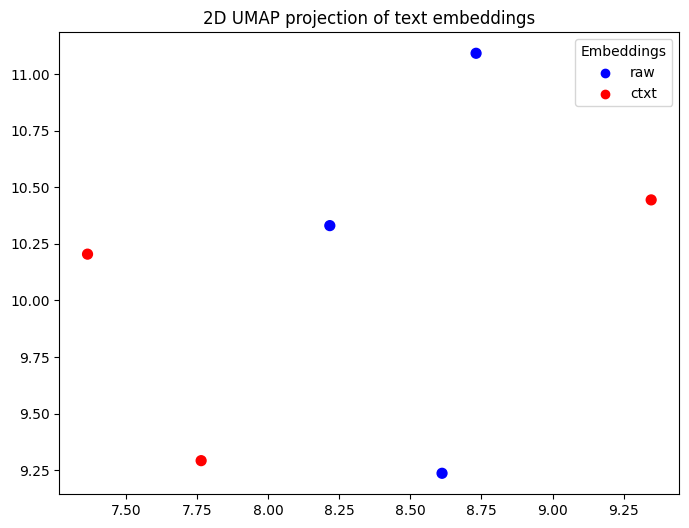

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=['b', 'b', 'b', 'r', 'r', 'r'], s=50)

# Legend workaround
plt.scatter([], [], c='b', label='raw')
plt.scatter([], [], c='r', label='ctxt')
plt.legend(title="Embeddings")

plt.title("2D UMAP projection of text embeddings")
plt.show()

# Quick check with FAISS

Is the lost context problem solved?

In [13]:
from pathlib import Path
Path().name

''

In [14]:
import faiss


dim = len(viz_embeddings[0])
index_raw = faiss.IndexFlatL2(dim)
index_raw.add(
    np.array([x.embedding for x in response_raw.data], dtype="float32")
    )

_q = "Which is the population of Berlin"
_q_vec = client_openai.embeddings.create(
    model=EMB_MODEL,
    input=_q
).data[0].embedding

distances, indices = index_raw.search(
    np.array([_q_vec], dtype="float32"),  # 2d array
    k=3
)

indices

array([[0, 1, 2]], dtype=int64)

In [15]:
lst_chunks[indices[0][0]]

'Berlin is the capital and largest city of Germany, both by area and by population.'

In [16]:
index_ctxt = faiss.IndexFlatL2(dim)
index_ctxt.add(
    np.array([x.embedding for x in response_ctxt.data], dtype="float32")
    )

_q = "Which is the population of Berlin"
_q_vec = client_openai.embeddings.create(
    model=EMB_MODEL,
    input=_q
).data[0].embedding

distances, indices = index_ctxt.search(
    np.array([_q_vec], dtype="float32"),  
    k=3
)

indices

array([[1, 0, 2]], dtype=int64)

In [17]:
lst_chunks[indices[0][0]]

"Its more than 3.85 million inhabitants make it the European Union's most populous city, as measured by population within city limits."

# Prompt Caching

* Minimun of 1024 tokens
* Incremental caching of +128 tokens
* In general, a prompt is cached during 5-10 min
![OpenAI implicit caching](https://openaidevs.retool.com/api/file/8593d9bb-4edb-4eb6-bed9-62bfb98db5ee)

In [18]:
lst_responses[0].usage.input_tokens

347

In [19]:
lst_responses[0].usage.input_tokens_details

InputTokensDetails(cached_tokens=0)

In [20]:
lst_responses[1].usage.input_tokens_details

InputTokensDetails(cached_tokens=0)

In [22]:
lst_responses[2].usage.input_tokens_details

InputTokensDetails(cached_tokens=0)